# W207 Final Project

## Submission by Sirisha Bhupathi and Abhi Sharma

This project is for the Kaggle competition listed here: https://www.kaggle.com/c/facial-keypoints-detection

## Objective

The objective of this project is to predict keypoint positions on face images.

## Introduction

The image sizes are 96 x 96 pixels and the key points are represented as location co-ordinates for each image. 
Location co-ordinates can have 2 values - one for x and one for y. 
There are a total of 30 location co-ordinates per image, 15 each for the x and y axis.
Out of the 30 co-ordinates in the test dataset for a single image, some co-ordinates are present and others need to be predicted. 
The number and type of co-ordinates that need to be predicted vary per test example.


In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# import keras, tf and image depdencies
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import tensorflow_hub as hub
from tensorflow.keras import layers



In [2]:
# We verify if the GPU is working and available with the following commands
# Adapted from here: https://www.tensorflow.org/guide/gpu

tf_config = tf.compat.v1.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.compat.v1.Session(config=tf_config)
tf.compat.v1.keras.backend.set_session(s)

gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
#tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)


if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)
Physical devices cannot be modified after being initialized


In [3]:
# Constants
IMG_DIM = 96
PIX_MAX = 255
IMAGE = 'Image'
columns = ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y']

CWD = '/project/notebooks'

In [4]:
folder_prefix = '..'
if os.getcwd() == CWD:
    folder_prefix = '/project/kaggle'

In [5]:
train = pd.read_csv(folder_prefix + '/input/facial-keypoints-detection/training.zip')
test = pd.read_csv(folder_prefix + '/input/facial-keypoints-detection/test.zip')
idlookup = pd.read_csv(folder_prefix + '/input/facial-keypoints-detection/IdLookupTable.csv')

In [6]:
print('Train shape:',train.shape)
print('Test shape:',test.shape)
print(test.head())
train.head().T

Train shape: (7049, 31)
Test shape: (1783, 2)
   ImageId                                              Image
0        1  182 183 182 182 180 180 176 169 156 137 124 10...
1        2  76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2        3  177 176 174 170 169 169 168 166 166 166 161 14...
3        4  176 174 174 175 174 174 176 176 175 171 165 15...
4        5  50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


In [7]:
# Check for missing values

train.isnull().any().value_counts()

True     28
False     3
dtype: int64

In [8]:
train.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

In [9]:
# Fill missing values with mean of the column

for col in columns:
    mean = np.mean(train[col])
    train[col] = train[col].fillna(mean)
train.isnull().any().value_counts()

False    31
dtype: int64

In [10]:
# Split image column and label columns

train_images = train[[IMAGE]]
train_labels = train.drop(IMAGE, axis=1)
train_labels.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [11]:
# Split train image pixels from string to 1 pixel per column and convert each pixel from string to float
train_images = train_images[IMAGE].str.split(' ', expand=True)
train_images = train_images.astype(float)

train_images.head()

,0,1,2,3,4,5,6,7,8,9,...,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215
0,238.0,236.0,237.0,238.0,240.0,240.0,239.0,241.0,241.0,243.0,...,33.0,29.0,30.0,34.0,39.0,49.0,62.0,70.0,75.0,90.0
1,219.0,215.0,204.0,196.0,204.0,211.0,212.0,200.0,180.0,168.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,144.0,142.0,159.0,180.0,188.0,188.0,184.0,180.0,167.0,132.0,...,64.0,60.0,56.0,61.0,70.0,69.0,71.0,78.0,78.0,77.0
3,193.0,192.0,193.0,194.0,194.0,194.0,193.0,192.0,168.0,111.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,147.0,148.0,160.0,196.0,215.0,214.0,216.0,217.0,219.0,220.0,...,33.0,34.0,37.0,37.0,43.0,46.0,83.0,140.0,170.0,176.0


In [12]:
# Split test image pixels from string to 1 pixel per column and convert each pixel from string to float
test_images = test.copy()
test_images = test_images.set_index('ImageId')
test_images = test_images[IMAGE].str.split(' ', expand=True)
test_images = test_images.astype(float)

test_images.head()

,0,1,2,3,4,5,6,7,8,9,...,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215
ImageId,,,,,,,,,,,,,,,,,,,,,
1,182.0,183.0,182.0,182.0,180.0,180.0,176.0,169.0,156.0,137.0,...,6.0,14.0,28.0,28.0,24.0,18.0,12.0,8.0,5.0,5.0
2,76.0,87.0,81.0,72.0,65.0,59.0,64.0,76.0,69.0,42.0,...,156.0,152.0,162.0,169.0,168.0,159.0,191.0,228.0,211.0,168.0
3,177.0,176.0,174.0,170.0,169.0,169.0,168.0,166.0,166.0,166.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,176.0,174.0,174.0,175.0,174.0,174.0,176.0,176.0,175.0,171.0,...,144.0,143.0,141.0,142.0,143.0,142.0,142.0,142.0,142.0,140.0
5,50.0,47.0,44.0,101.0,144.0,149.0,120.0,58.0,48.0,42.0,...,254.0,254.0,254.0,253.0,255.0,236.0,174.0,175.0,175.0,165.0


In [13]:
# Instead of flat representation, have a dataframe with 2d representation of each row's image as well
train_images_2d = train_images.values.reshape(-1, IMG_DIM, IMG_DIM, 1)
test_images_2d = test_images.values.reshape(-1, IMG_DIM, IMG_DIM, 1)

print(train_images_2d.shape)
print(test_images_2d.shape)

(7049, 96, 96, 1)
(1783, 96, 96, 1)


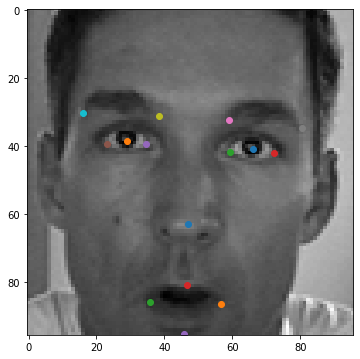

In [14]:
# Plot images and keypoints

# Can try different images
image_no = 60 

plt.figure(figsize=(6,6))
plt.imshow(np.array(train_images.iloc[image_no]).reshape(IMG_DIM, IMG_DIM),cmap='gray')
for i in range(0, 30, 2):
    plt.scatter(train_labels.iloc[image_no][i],train_labels.iloc[image_no][i+1])
plt.show()

In [15]:
# Normalize train and test data

train_images = train_images/PIX_MAX
train_labels = train_labels/IMG_DIM
test_images = test_images/PIX_MAX

In [16]:
num_train_examples = train_images.shape[0]
num_train_examples

7049

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras import optimizers
from keras.layers import Conv2D,Dropout,Dense,Flatten
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D
import tensorflow as tf

model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
# model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()

model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mse','mae'])

history = model.fit(train_images_2d, train_labels, epochs = 50,batch_size = int(num_train_examples/100),validation_split = 0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 32)       

81/81 [==============================] - 2s 30ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0495 - val_loss: 0.0019 - val_mse: 0.0019 - val_mae: 0.0244
Epoch 13/50
81/81 [==============================] - 2s 30ms/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0471 - val_loss: 6.3665e-04 - val_mse: 6.3665e-04 - val_mae: 0.0134
Epoch 14/50
81/81 [==============================] - 2s 30ms/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0472 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0157
Epoch 15/50
81/81 [==============================] - 2s 30ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0453 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0172
Epoch 16/50
81/81 [==============================] - 2s 30ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0433 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0228
Epoch 17/50
81/81 [==============================] - 2s 30ms/step - loss: 0.0036 - mse: 0.0036 - mae: 0.0431 - val_loss: 6.9805e-04 - val_mse: 6.9805e-04 - val_mae: 0.0156
Epoch 18/50


In [19]:
# Predict for test
pred = model.predict(test_images_2d)
print(np.min(pred))
print(np.max(pred))
print(np.min(model.predict(train_images_2d)))

0.14502367
0.91388726
0.14193663


In [20]:
# Look up table
print(idlookup.head(2))
idlookup = idlookup.drop('Location',axis=1)
print(idlookup.head(2))

   RowId  ImageId        FeatureName  Location
0      1        1  left_eye_center_x       NaN
1      2        1  left_eye_center_y       NaN
   RowId  ImageId        FeatureName
0      1        1  left_eye_center_x
1      2        1  left_eye_center_y


In [21]:
feature_names = train_labels.columns
predictions = pd.DataFrame(pred, columns = feature_names)
predictions = predictions * IMG_DIM

predictions.head()
predictions.stack().reset_index()
predictions = predictions.stack().reset_index()
predictions.columns = ['index','FeatureName','Location']

imageids = test['ImageId']
imageids = imageids.reset_index()

predictions = predictions.merge(imageids, left_on='index', right_on='index')
predictions = predictions.drop('index',axis=1)

predictions

,FeatureName,Location,ImageId
0,left_eye_center_x,65.683426,1
1,left_eye_center_y,37.005028,1
2,right_eye_center_x,30.319645,1
3,right_eye_center_y,36.899151,1
4,left_eye_inner_corner_x,59.846657,1
...,...,...,...
53485,mouth_right_corner_y,76.761909,1783
53486,mouth_center_top_lip_x,47.040142,1783
53487,mouth_center_top_lip_y,73.188332,1783
53488,mouth_center_bottom_lip_x,46.813007,1783


In [22]:
submission = idlookup.merge(predictions, left_on=['FeatureName','ImageId'], right_on=['FeatureName','ImageId'])
submission = submission[['RowId','Location']]
submission = submission.set_index('RowId')
submission

,Location
RowId,
1,65.683426
2,37.005028
3,30.319645
4,36.899151
5,59.846657
...,...
27120,38.209949
27121,46.107883
27122,62.880512


In [23]:
# Save submission result
    
if os.getcwd() == CWD:
    os.chdir('/project')
    # make submissions directory if it doesnt exist
    try:
        os.makedirs('submissions')
    except OSError as e:
        pass
    
    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S").replace('/','').replace(':','').replace(' ','')
    submission.to_csv('submissions/submission-{0}.csv'.format(dt_string))
    os.chdir(CWD)
    
else:
    submission.to_csv('submission.csv')